In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Import required libraries
import os
import zipfile
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalMaxPooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.svm import SVC

In [ ]:
# # Set the path to your zip file in Google Drive
zip_path = '/content/drive/MyDrive/Data.zip'

# # Set the path to your output directory
output_dir = '/content/output'

# # Extract the zip file to the output directory
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
     zip_ref.extractall(output_dir)

In [ ]:
# Tuberculosis Chest X-ray Database is used from Kaggle
train_path = "/content/output/Data/train"
test_path = "/content/output/Data/test"

In [ ]:
img_size = (224, 224)
num_channels = 3
batch_size = 32
num_classes = 2

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)
test_labels = test_generator.classes

Found 1120 images belonging to 2 classes.
Found 280 images belonging to 2 classes.


In [ ]:
# Load the InceptionV3 model without the top layer
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [ ]:
# Add GlobalMaxPooling2D layer to replace the GlobalAveragePooling2D layer
x = base_model.output
x = GlobalMaxPooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

In [ ]:
model = Model(inputs=base_model.input, outputs=predictions)

In [ ]:
# Freeze the layers in the base model
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# Train the model
history = model.fit(train_generator, epochs=10, validation_data=test_generator)
model.save('/content/drive/MyDrive/TB_Detection_Models/tb_detection_new_model.h5')

Epoch 1/10
35/35 [==============================] - 234s 7s/step - loss: 0.1252 - accuracy: 0.9509 - val_loss: 0.0906 - val_accuracy: 0.9643
Epoch 2/10
35/35 [==============================] - 191s 5s/step - loss: 0.1240 - accuracy: 0.9473 - val_loss: 0.0809 - val_accuracy: 0.9714
Epoch 3/10
35/35 [==============================] - 188s 5s/step - loss: 0.0991 - accuracy: 0.9607 - val_loss: 0.1753 - val_accuracy: 0.9464
Epoch 4/10
35/35 [==============================] - 198s 6s/step - loss: 0.1212 - accuracy: 0.9536 - val_loss: 0.0822 - val_accuracy: 0.9679
Epoch 5/10
35/35 [==============================] - 190s 5s/step - loss: 0.1129 - accuracy: 0.9509 - val_loss: 0.0900 - val_accuracy: 0.9750
Epoch 6/10
35/35 [==============================] - 194s 6s/step - loss: 0.1172 - accuracy: 0.9554 - val_loss: 0.1234 - val_accuracy: 0.9607
Epoch 7/10
35/35 [==============================] - 189s 5s/step - loss: 0.0983 - accuracy: 0.9625 - val_loss: 0.1101 - val_accuracy: 0.9607
Epoch 8/10
35

In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/TB_Detection_Models/tb_detection_new_model.h5')

In [ ]:
loss, accuracy = model.evaluate(test_generator)
print('Test accuracy:', accuracy)

9/9 [==============================] - 45s 4s/step - loss: 0.0808 - accuracy: 0.9714
Test accuracy: 0.9714285731315613


In [ ]:
# Extract features using the model
train_features = model.predict(train_generator)

test_features = model.predict(test_generator)

9/9 [==============================] - 39s 4s/step


In [ ]:
# Train an SVM classifier on the extracted features
print(train_generator.classes)
svm = SVC(kernel='linear',C=1, gamma='auto')
svm.fit(train_features, train_generator.classes)

[0 0 0 ... 1 1 1]


SVC(C=1, gamma='auto', kernel='linear')

In [ ]:
predicted_classes = svm.predict(test_features)

print(predicted_classes)
print(test_labels)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

In [ ]:
test_image_path = '/content/output/Data/test/Tuberculosis/Tuberculosis-666.png'
test_image = load_img(test_image_path, target_size=(224, 224))
# Preprocess the test image
test_image_array = img_to_array(test_image)
test_image_array = np.expand_dims(test_image_array, axis=0)
test_image_array = test_image_array / 255.0

In [ ]:
# Extract features using the trained model
test_features = model.predict(test_image_array)

1/1 [==============================] - 2s 2s/step


In [ ]:
# Use the SVM classifier to predict the class of the test image
predicted_class = svm.predict(test_features)

In [ ]:
# Print the predicted class
if predicted_class == 0:
    print('The test image is normal.')
elif predicted_class == 1:
    print('The test image has TB.')

The test image has TB.


Precision: 0.9714285714285714
Recall: 0.9714285714285714
F1 score: 0.9714285714285714


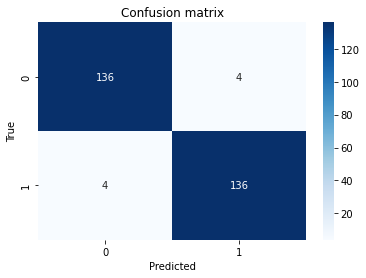

In [ ]:
# Plot the confusion matrix
from sklearn.metrics import precision_score, recall_score, f1_score,confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

precision = precision_score(test_labels, predicted_classes, pos_label=1)
recall = recall_score(test_labels, predicted_classes, pos_label=1)
f1 = f1_score(test_labels, predicted_classes, pos_label=1)

print("Precision:", precision)
print("Recall:", recall)
print("F1 score:", f1)

from sklearn.metrics import confusion_matrix


cm = confusion_matrix(test_labels, predicted_classes)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion matrix')
plt.show()

In [ ]:
# Plot the classification report
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

target_names = ['Negative', 'Positive']
print("Accuracy_score:",accuracy_score(test_labels, predicted_classes))
print(classification_report(test_labels, predicted_classes, target_names=target_names))

Accuracy_score: 0.9714285714285714
              precision    recall  f1-score   support

    Negative       0.97      0.97      0.97       140
    Positive       0.97      0.97      0.97       140

    accuracy                           0.97       280
   macro avg       0.97      0.97      0.97       280
weighted avg       0.97      0.97      0.97       280

